<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Cell-Tidy-Data" data-toc-modified-id="Cell-Tidy-Data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cell Tidy Data</a></span></li><li><span><a href="#Gene-Metadata" data-toc-modified-id="Gene-Metadata-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Gene Metadata</a></span></li><li><span><a href="#MCDS" data-toc-modified-id="MCDS-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>MCDS</a></span></li><li><span><a href="#Cluster-Markers" data-toc-modified-id="Cluster-Markers-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Cluster Markers</a></span></li></ul></li><li><span><a href="#Category-Plot" data-toc-modified-id="Category-Plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Category Plot</a></span></li><li><span><a href="#Plot-Genes" data-toc-modified-id="Plot-Genes-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot Genes</a></span><ul class="toc-item"><li><span><a href="#Single-Gene" data-toc-modified-id="Single-Gene-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Single Gene</a></span></li><li><span><a href="#Multiple-Genes" data-toc-modified-id="Multiple-Genes-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Multiple Genes</a></span></li><li><span><a href="#Cluster-Markers" data-toc-modified-id="Cluster-Markers-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Cluster Markers</a></span></li></ul></li><li><span><a href="#Manual-Annotation" data-toc-modified-id="Manual-Annotation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Manual Annotation</a></span></li></ul></div>

# Cluster Marker Identification

## Purpose
- Visualizing markers
- Annotate Cluster

## Input
- gene MCDS
- consensus clustering
- Cluster marker list

## Output
- Annotated clusters

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *

In [3]:
result_dir = pathlib.Path('Annotation')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/cluster_annot')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
gene_annotation_path = '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz'
cell_tidy_data_path = './Cluster/cell_tidy_data.with_cluster.msg'
gene_mcds_pattern = './Adata/SelectedCell*gene_da_rate*mcds'

load = True
mc_type = 'CHN'

cluster_col_name = 'consensus_cluster_rescued'
coord_base = 'umap'

In [5]:
# Parameters
load = False
mc_type = "CHN"
coord_base = "umap"


## Load

### Cell Tidy Data

In [6]:
cell_tidy_data = pd.read_msgpack(cell_tidy_data_path)

raw_cell_tidy_data = cell_tidy_data.copy()

### Gene Metadata

In [7]:
gene_meta = pd.read_csv(gene_annotation_path, index_col='gene_id', sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v:k for k, v in gene_meta['gene_name'].iteritems()}
gene_id_base_to_id = pd.Series(gene_meta.index, index = gene_meta.index.map(lambda i: i.split('.')[0])).to_dict()

### MCDS

In [8]:
gene_mcds = MCDS.open(gene_mcds_pattern,
                      combine='nested',
                      concat_dim='cell').sel(mc_type=mc_type)['gene_da']
gene_mcds.chunk({'gene': 100, 'cell': 999999})

if load:
    gene_mcds.load()

[1]


In [9]:
def get_gene_data(gene):
    if gene.startswith('ENSMUSG'):
        gene_id = gene
    else:
        gene_id = gene_name_to_id[gene]
    gene_data = gene_mcds.sel(gene=gene_id).to_pandas()
    return gene_data

### Cluster Markers

In [10]:
name_df = pd.read_msgpack(f'./Marker/{mc_type}_marker_name.msg')
score_df = pd.read_msgpack(f'./Marker/{mc_type}_marker_test_score.msg')
fold_change_df = pd.read_msgpack(f'./Marker/{mc_type}_marker_fold_change.msg')

## Category Plot

[Text(0.5, 1.0, 'consensus_cluster_rescued')]

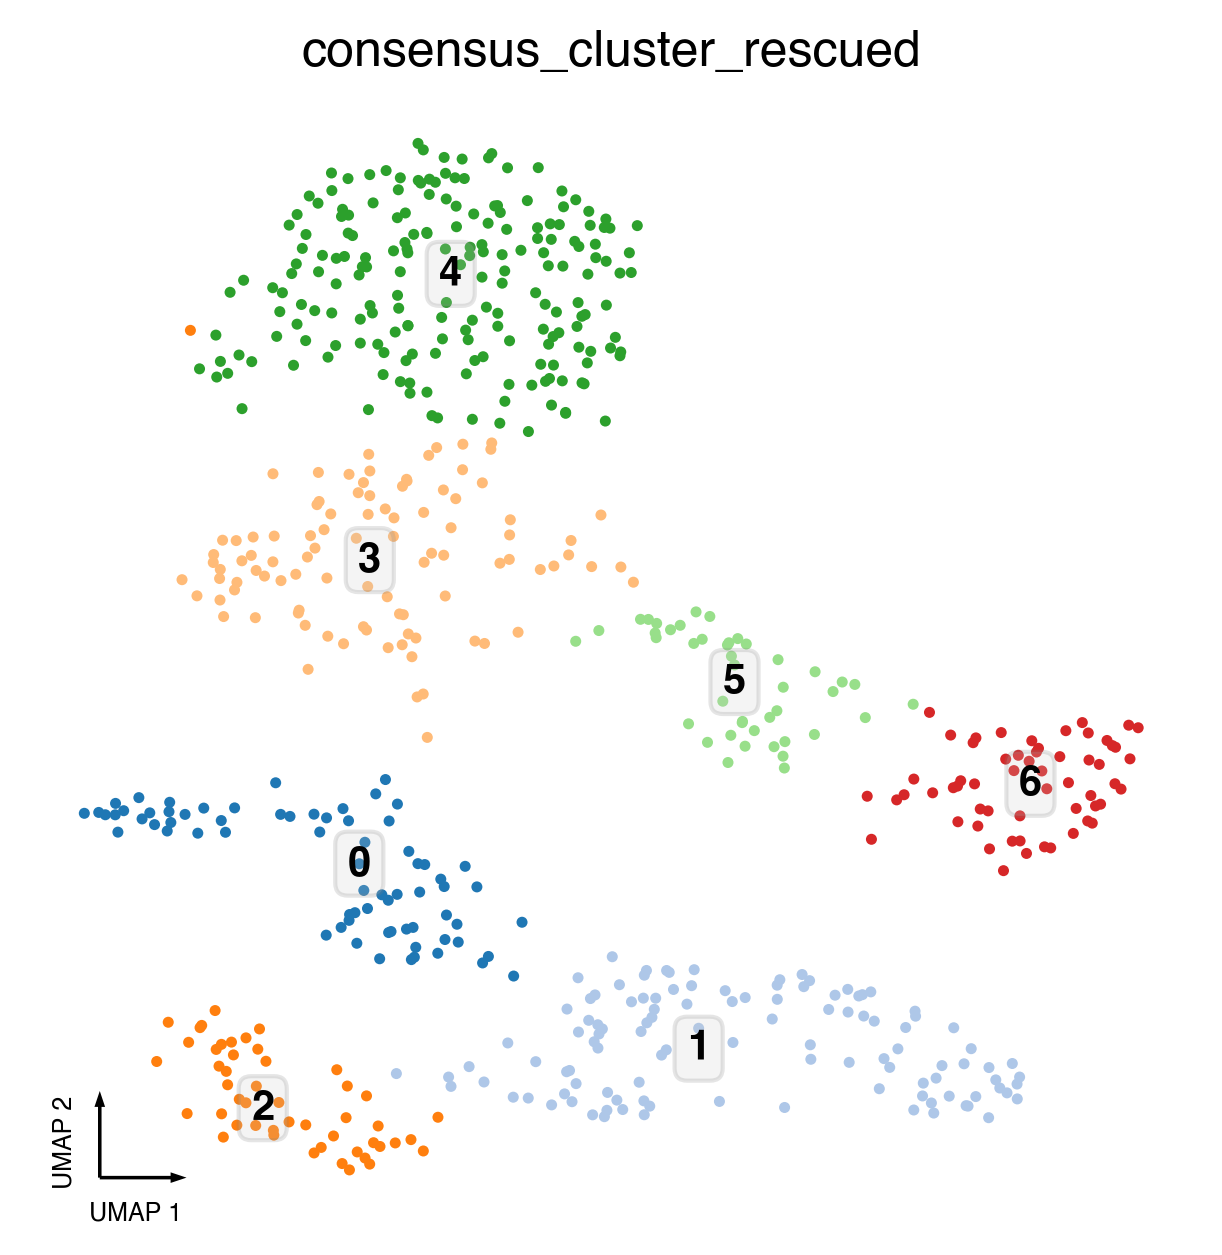

In [11]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, ncols=1)
categorical_scatter(data=cell_tidy_data,
                    coord_base=coord_base,
                    ax=ax,
                    hue=cluster_col_name,
                    palette='tab20',
                    text_anno=cluster_col_name)
ax.set(title=cluster_col_name)

## Plot Genes

### Single Gene

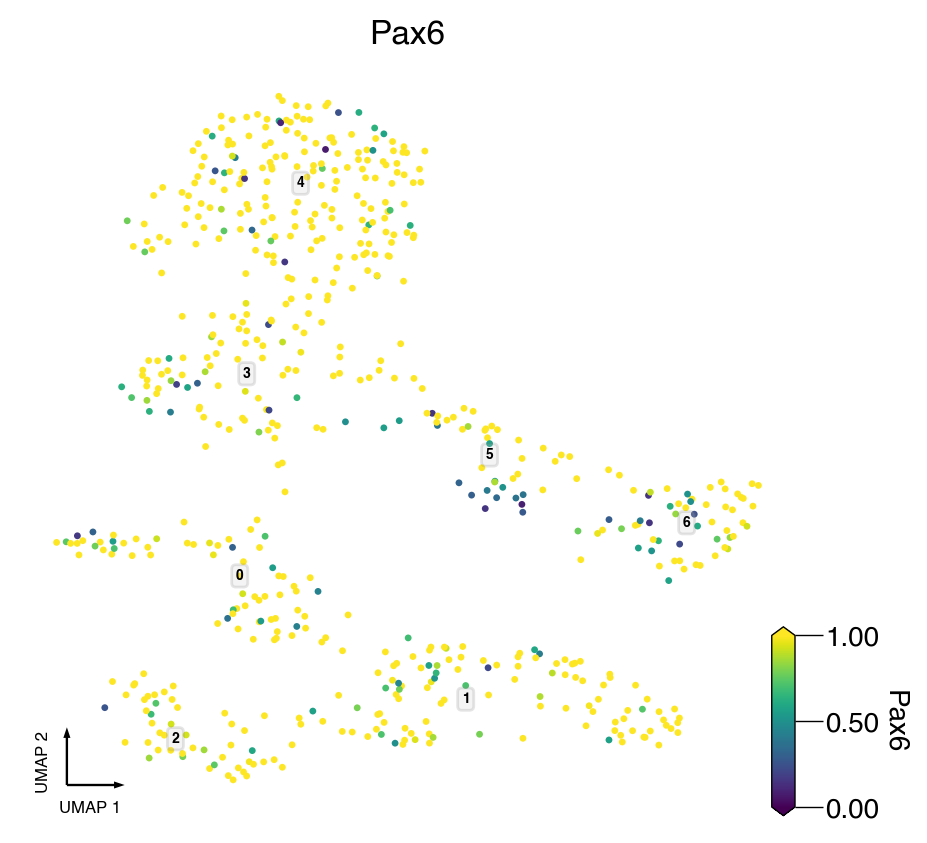

In [12]:
gene_name = 'Pax6'

gene_id = gene_name_to_id[gene_name]
fig, ax = plt.subplots(figsize=(5, 5), nrows=1, ncols=1, dpi=200)
if gene_name not in cell_tidy_data.columns:
    cell_tidy_data[gene_name] = get_gene_data(gene_id)
continuous_scatter(cell_tidy_data,
                   ax,
                   coord_base=coord_base,
                   hue=gene_name,
                   hue_norm=(0, 1),
                   text_anno=cluster_col_name,
                   scatter_kws=dict(s=6),
                   text_anno_kws=dict(fontsize=5),
                   max_points=2500)
ax.set_title(gene_name)
fig.savefig(fig_dir / f'{gene_name}_{mc_type}_Cluster_Marker.pdf')

### Multiple Genes

In [13]:
genes = ['Vip', 'Ndnf', 'Lamp5', 'Chat', 'Adarb2', 'Lhx6']
ncols = 4

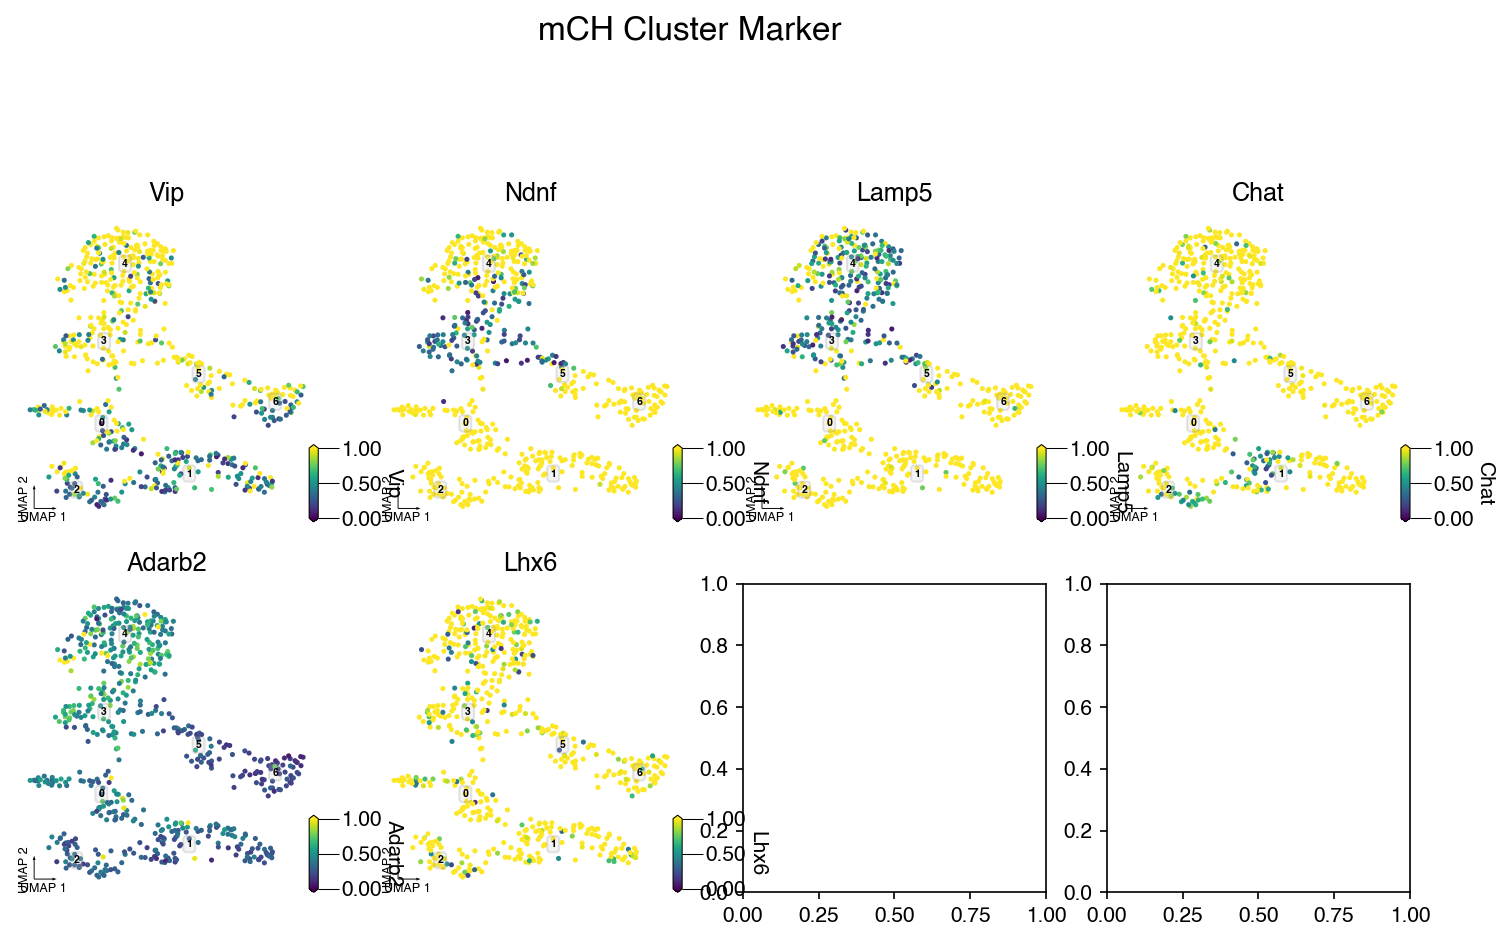

In [14]:
if len(genes) != 0:
    gene_ids = [gene_name_to_id[i] for i in genes]

    nrows = len(genes) // ncols + (1 if (len(genes) % ncols != 0) else 0)
    fig, axes = plt.subplots(figsize=(3*ncols, 3*nrows), nrows=nrows, ncols=ncols, dpi=150)
    for gene, gene_id, ax in zip(genes, gene_ids, axes.flat):
        #if gene not in cell_tidy_data.columns:
        cell_tidy_data[gene] = get_gene_data(gene_id)
        continuous_scatter(cell_tidy_data,
                           ax,
                       coord_base=coord_base, 
                       hue=gene,
                       hue_norm=(0, 1),
                       text_anno=cluster_col_name,
                       scatter_kws=dict(s=6),
                       text_anno_kws=dict(fontsize=5),
                       max_points=2500)
        ax.set_title(gene)
    fig.suptitle(f'mCH Cluster Marker', fontsize=16, y=1.1)
    all_gene = '_'.join(genes)
    fig.savefig(fig_dir / f'Cluster_Markers.pdf')

### Cluster Markers

In [15]:
cluster = '5'
n_genes = 10
nrows = 2
coord_base='umap'

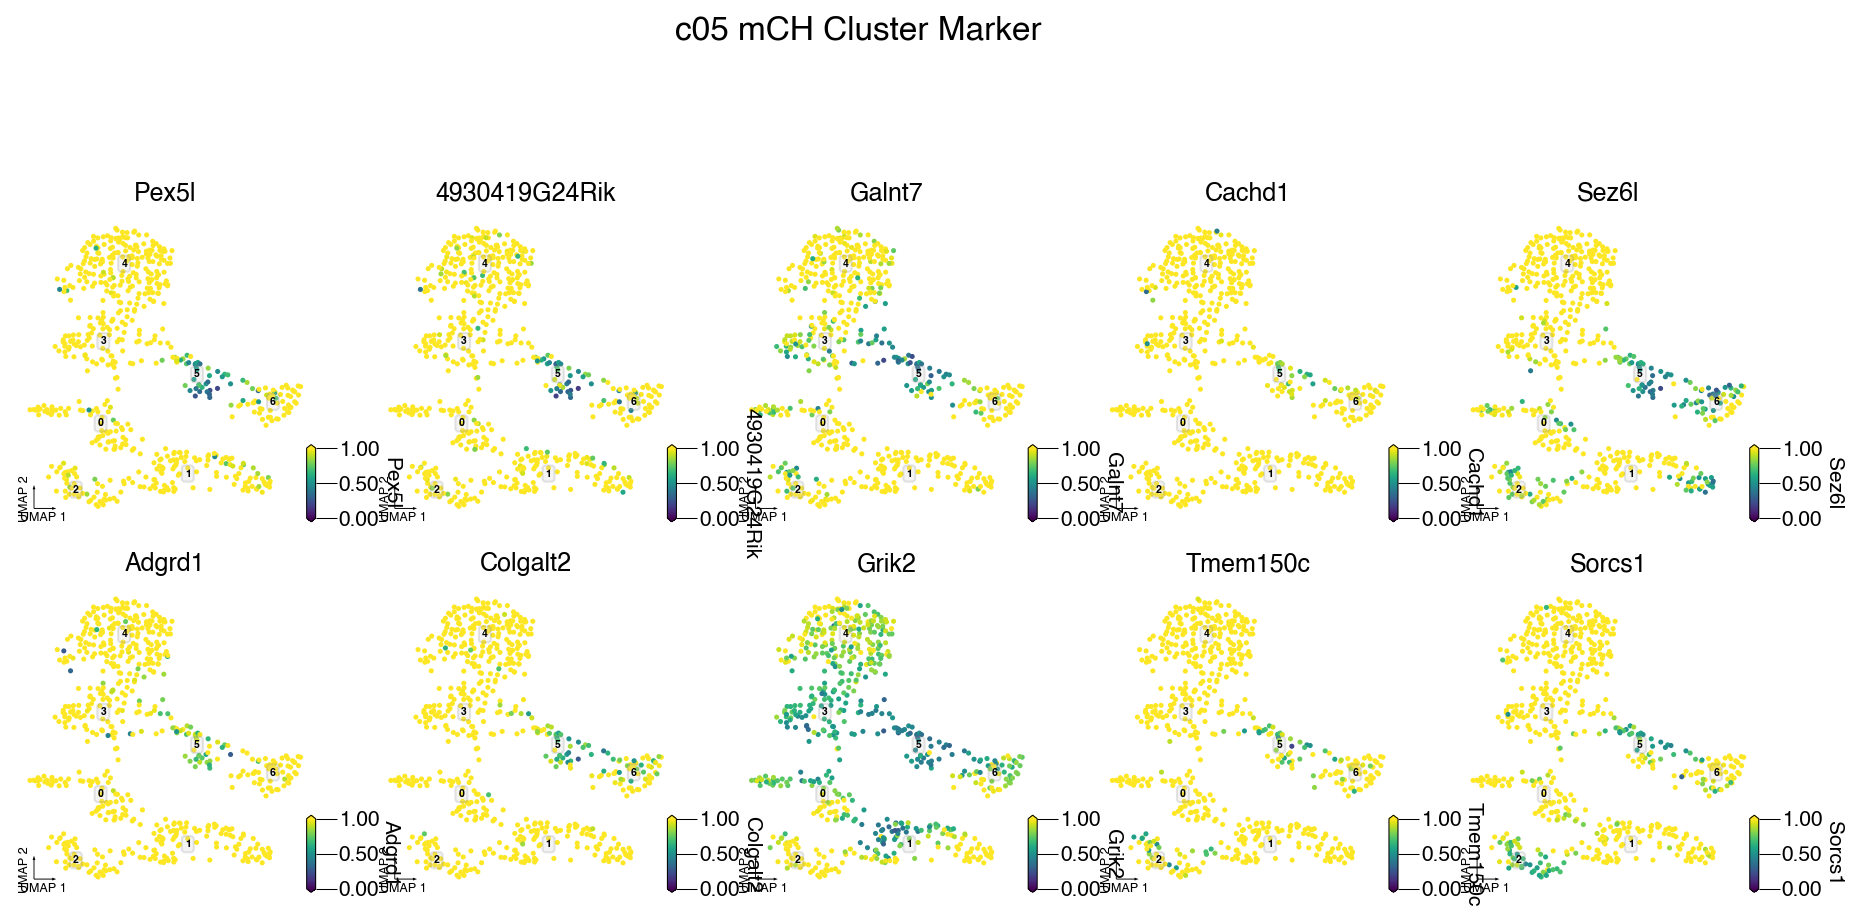

In [16]:
gene_ids = name_df.iloc[:n_genes, int(cluster)]
genes = [gene_meta.loc[gene_id, 'gene_name'] for gene_id in gene_ids]

ncols = len(genes) // nrows
fig, axes = plt.subplots(figsize=(3*ncols, 3*nrows), nrows=nrows, ncols=ncols, dpi=150)
for gene, gene_id, ax in zip(genes, gene_ids, axes.flat):
    if gene not in cell_tidy_data.columns:
        cell_tidy_data[gene] = get_gene_data(gene_id)
    continuous_scatter(cell_tidy_data,
                       ax,
                       coord_base=coord_base, 
                       hue=gene,
                       hue_norm=(0, 1),
                       text_anno=cluster_col_name,
                       scatter_kws=dict(s=6),
                       text_anno_kws=dict(fontsize=5),
                       max_points=2500)
    ax.set_title(gene)
fig.suptitle(f'c{int(cluster):02d} mCH Cluster Marker', fontsize=16, y=1.1)
fig.savefig(fig_dir / f'c{int(cluster):02d}_{mc_type}_Cluster_Marker.pdf')

## Manual Annotation

In [17]:
cell_tidy_data[cluster_col_name].value_counts()

4    196
1    111
3     96
0     71
6     58
2     50
5     43
Name: consensus_cluster_rescued, dtype: int64

In [18]:
{i:'' for i in sorted(cell_tidy_data[cluster_col_name].unique())}

{0: '', 1: '', 2: '', 3: '', 4: '', 5: '', 6: ''}

In [19]:
cluster_name_map = {0: 'Vip-Prr16', 
1: 'Vip-Ano4', 
2: 'Vip-Sorcs1', 
3: 'Lamp5-Ndnf', 
4: 'Lamp5-Unc5d', 
5: 'Pex5l', 
6: 'Vip-Unc5b'}

In [20]:
raw_cell_tidy_data[cluster_col_name + "_anno"] = cell_tidy_data[cluster_col_name].apply(lambda i: cluster_name_map[i] if i in cluster_name_map else i)

In [21]:
raw_cell_tidy_data.to_msgpack('cell_tidy_data.final_annotation.msg')

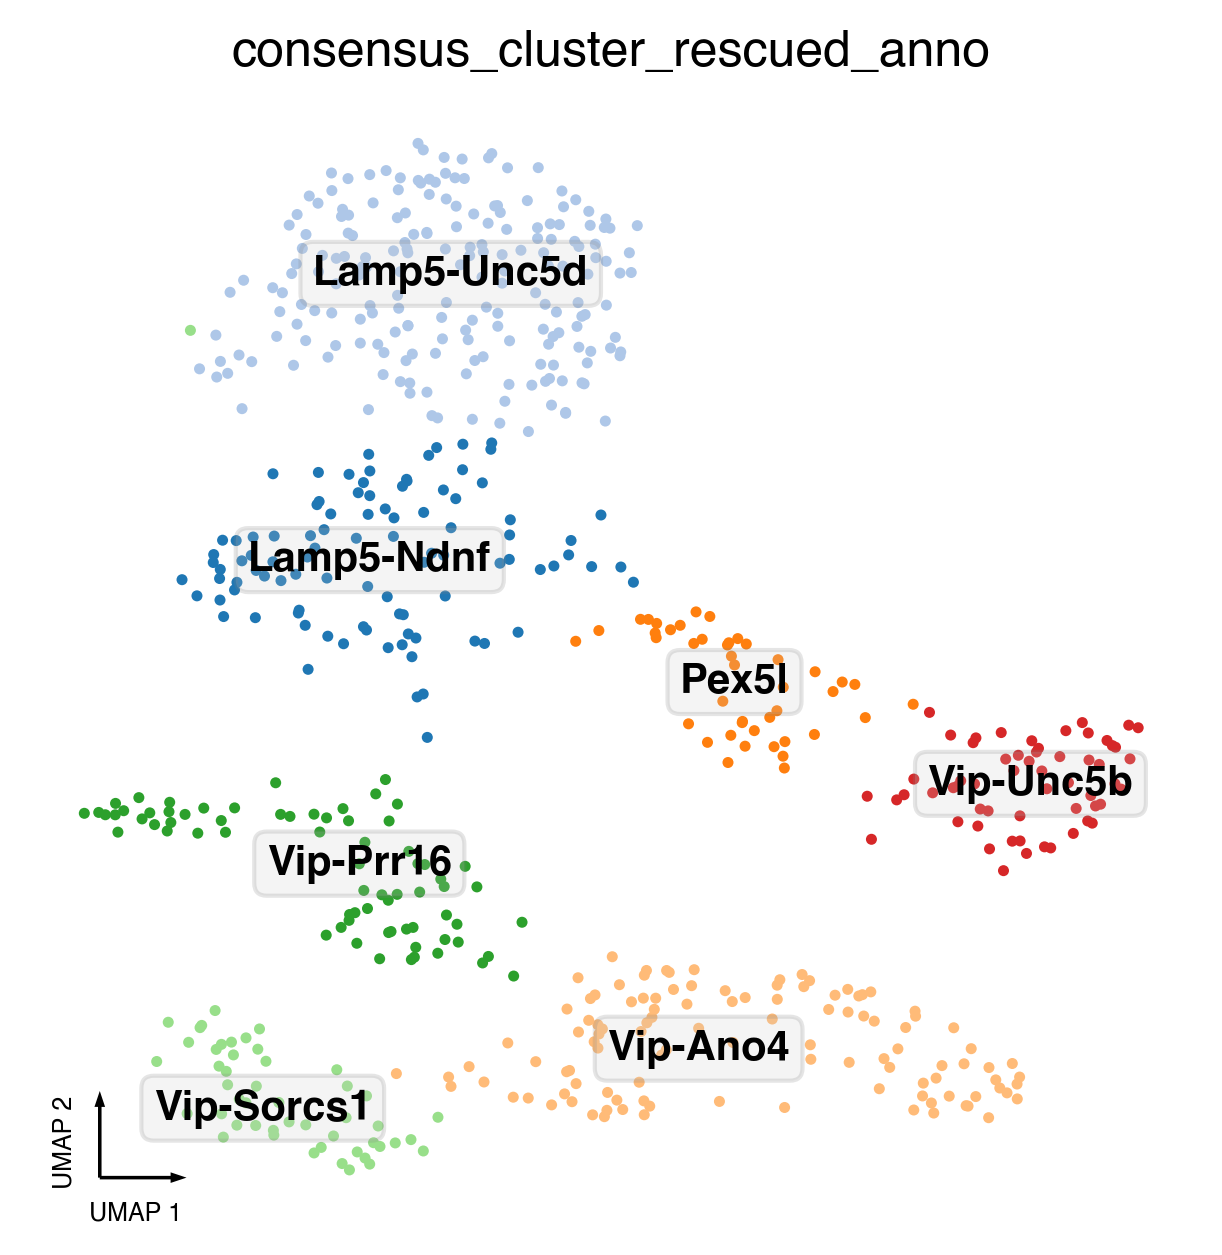

In [22]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, ncols=1)
categorical_scatter(data=raw_cell_tidy_data,
                    coord_base=coord_base,
                    ax=ax,
                    hue=cluster_col_name + "_anno",
                    palette='tab20',
                    text_anno=cluster_col_name + "_anno")
ax.set(title=cluster_col_name + "_anno")
fig.savefig(fig_dir / 'FinalClusterAnno.pdf')